In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, GPT2Tokenizer

PROMPT = "Once upon a time"
MODEL_PATH = "gpt2-medium"
NUM_TOKENS = 20

# tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M") # TinyStories, GPTNeo
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

input_ids = tokenizer(PROMPT, return_tensors="pt").input_ids
current_ids = input_ids

model = AutoModelForCausalLM.from_pretrained(MODEL_PATH)
model.eval()

/opt/anaconda3/envs/lipshutz/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

#### Get the hidden layer activations from a sentence generated by the model

In [ ]:
# I need to hook into each hidden layer and for each next generated word.
response_activations = []   # list of list (num_tokens × num_layers)
generated_tokens = []
current_ids = input_ids

period_id = tokenizer.encode(".", add_special_tokens=False)[0] # For sentence tracking
sentence_count = 0
for step in range(NUM_TOKENS):

    # Forward pass with hidden states returned
    with torch.no_grad():
        outputs = model(current_ids, output_hidden_states=True)

    # outputs.hidden_states is a tuple: 
    # (embedding, layer0_out, layer1_out, ..., layerN_out) for GPT-2
    # for GPT-Neo, there is no embedding layer. 
    all_h = outputs.hidden_states
    if all_h[0].shape[-1] == model.config.hidden_size:
        layer_states = all_h # GPT-Neo: no embedding layer
    else:
        layer_states = all_h[1:] # GPT-2

    # hidden_states[j] shape: (batch=1, seq_len, hidden_size)
    # where seq_len is fro mthe last token generated
    last_token_activations = [
        h[0, -1, :].cpu() for h in layer_states
    ]

    # Store activations for this step
    response_activations.append(last_token_activations)

    # Sample next token
    next_token = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(-1)
    token_id = next_token.item()

    # Append token to the running input
    current_ids = torch.cat([current_ids, next_token], dim=1)
    generated_tokens.append(next_token.item())
    if token_id == period_id:
        sentence_count += 1


num_generated = len(response_activations)
num_layers = len(response_activations[0])

print(f"Generated {num_generated} tokens")
print(f"Each token has activations for {num_layers} layers")
print(f"Example activation shape: {response_activations[0][0].shape}") 

full_output_ids = torch.cat([input_ids, torch.tensor([generated_tokens])], dim=1)
generated_text = tokenizer.decode(full_output_ids[0], skip_special_tokens=True)

print("Model Generated:")
print(generated_text)


Generated 20 tokens
Each token has activations for 25 layers
Example activation shape: torch.Size([1024])
Model Generated:
Once upon a time, there was a man who lived in a village called Krakow. He was a very good


#### Get the hidden layer activations from PROMPT (incrementally giving the sentence to the LLM to record outputs)

In [ ]:

num_tokens = input_ids.shape[1]
response_activations = []  # list of list (num_tokens × num_layers)

for step in range(num_tokens):
    # Take first (step+1) tokens
    current_ids = input_ids[:, : step + 1]

    with torch.no_grad():
        outputs = model(current_ids, output_hidden_states=True)

    # Normalize hidden-states indexing for GPT-2 or other style architectures
    all_h = outputs.hidden_states
    if all_h[0].shape[-1] == model.config.hidden_size:
        layer_states = all_h  #
    else:
        layer_states = all_h[1:] 

    # Capture activations of the **last token** in sequence
    last_token_activations = [h[0, -1, :].cpu() for h in layer_states]

    response_activations.append(last_token_activations)

# Print dimensions and outputs for verifcation. 
num_layers = len(response_activations[0])
print(f"Processed {num_tokens} tokens from input sentence")
print(f"Each token has activations for {num_layers} layers")
print(f"Example activation shape: {response_activations[0][0].shape}")
decoded_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
print("\nInput sentence decoded:")
print(decoded_text)


NameError: name 'input_ids' is not defined

#### Get the adjacency vectors (difference in the hidden layers for given word, w).

In [3]:
adjacent_states = []
for p in range(num_layers):
    layer_diffs = []
    for k in range(num_generated - 1):
        diff = response_activations[k+1][p] - response_activations[k][p]
        layer_diffs.append(diff)
    adjacent_states.append(layer_diffs)
# Validate the shape is correct
print(len(adjacent_states))                # num_layers
print(len(adjacent_states[0]))             # num_tokens - 1
print(adjacent_states[0][0].shape) 

25
19
torch.Size([1024])


#### Calculate the curvature for each word, w.

In [4]:
import math

curvatures = [] # (num_layers x num_tokens - 1 - 1)

for p in range(num_layers): 
    p_curvatures = []
    for k in range(len(adjacent_states[0])-1):
        adjacency_product = np.dot(adjacent_states[p][k+1], adjacent_states[p][k])
        norm_product = np.linalg.norm(adjacent_states[p][k+1]) * np.linalg.norm(adjacent_states[p][k])
        curvature = math.acos((adjacency_product / norm_product))
        p_curvatures.append(curvature)

    curvatures.append(p_curvatures)


print(f"Len of curvatures = {len(curvatures)}")
print(f"Len of a curvature element = {len(curvatures[0])}")

avg_curvatures = [(np.sum(c) / np.linalg.norm(c)) for c in curvatures]
print(f"Len of avg_curvatures = {len(avg_curvatures)}")

change_in_avg_curvatures = [ (c - avg_curvatures[0]) for c in avg_curvatures]
avg_change = np.average(change_in_avg_curvatures)

Len of curvatures = 25
Len of a curvature element = 18
Len of avg_curvatures = 25


/var/folders/2k/6js25dxx5_3d034p40m62gkh0000gn/T/ipykernel_13939/492212966.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  adjacency_product = np.dot(adjacent_states[p][k+1], adjacent_states[p][k])


#### Graph the change in curvature across each layer for a given word.

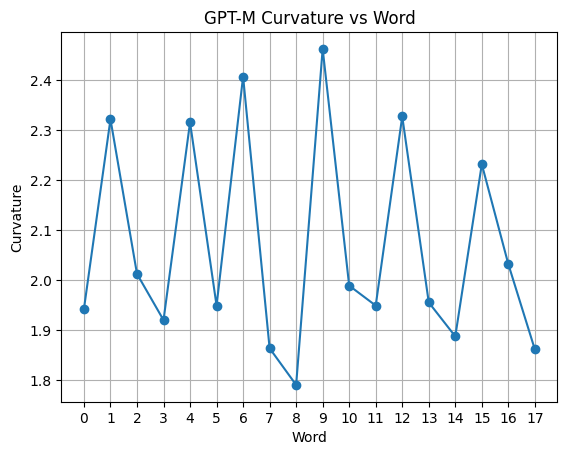

In [5]:
LAYER_IDX = 1
plt.plot(range(len(curvatures[LAYER_IDX])), curvatures[LAYER_IDX], marker='o')

plt.xlabel("Word")
plt.ylabel("Curvature")

plt.xticks(range(len(curvatures[LAYER_IDX])))   # <-- force integer ticks

plt.title("GPT-M Curvature vs Word")
plt.grid(True)

plt.savefig("gptm_curvature_per_word.png")

#### Graph the average curvature for each layer

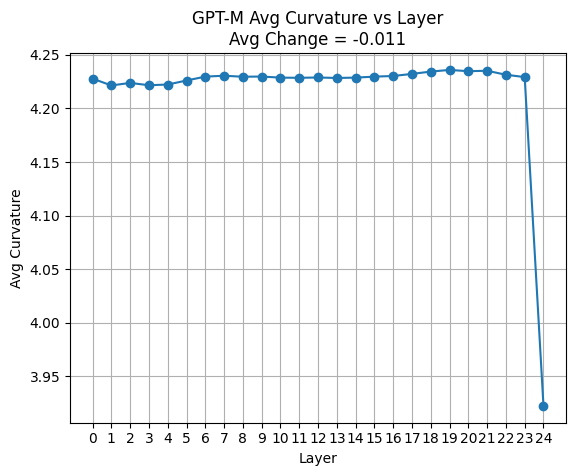

In [6]:
plt.plot(range(len(avg_curvatures)), avg_curvatures, marker='o')

plt.xlabel("Layer")
plt.ylabel("Avg Curvature")

plt.xticks(range(len(avg_curvatures))) # <-- force integer ticks

plt.title(f"GPT-M Avg Curvature vs Layer\nAvg Change = {np.round(avg_change, 3)}")
plt.grid(True)

plt.savefig("gptm_avg_curvature_per_layer.png")

#### Graph the change in curvatures

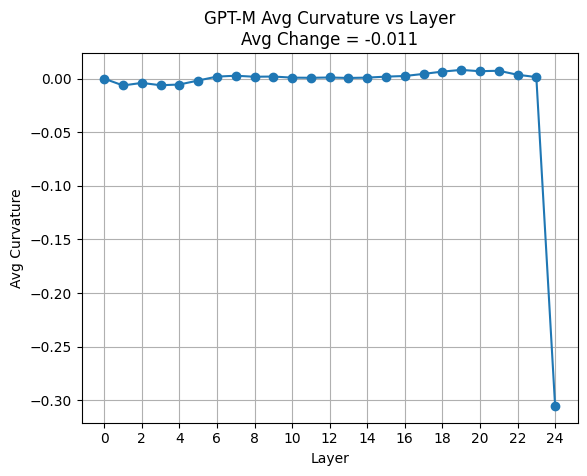

In [11]:
plt.plot(range(len(change_in_avg_curvatures)), change_in_avg_curvatures, marker='o')

plt.xlabel("Layer")
plt.ylabel("Avg Curvature")

plt.xticks(range(0, len(change_in_avg_curvatures), 2)) # <-- force integer ticks

plt.title(f"GPT-M Avg Curvature vs Layer\nAvg Change = {np.round(avg_change, 3)}")
plt.grid(True)
plt.show()